In [ ]:
import os
import sys

import pandas as pd
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.insert(0, SRC_DIR)
from preprocessing import preprocess, get_labels
from alex.outlier_utils import isolation_forest_mask, remove_outliers
from alex.plots import plot_feature_importances
from alex.random_forest import (
    rf_baseline,
    rf_mi_only,
    rf_tuned_only,
    rf_mi_tuned,
)
from sklearn.preprocessing import LabelEncoder

## 

# Random Forest Classification

This notebook evaluates 5 scenarios of Random Forest configurations on the plant health dataset. This uses the functions created in `src/alex/random_forest.py`, I just wanted a clean notebook showcasing the results, without needing to run that file. Please reference the other file for the implementations.

## Breakdown of the different scenarios:

1. **Scenario 1 – Baseline RF**  
   - Random Forest with base parameters set
   - No feature selection, no hyperparameter tuning, no explicit outlier handling

2. **Scenario 2 – RF + Mutual Information (MI)**  
   - Same RF as Scenario 1, but with mutual information feature selection on the input features

3. **Scenario 3 – RF tuned**  
   - Random Forest with an extensive grid search over depth, number of trees, and minimum samples. 
   - No feature selection

4. **Scenario 4 – RF + MI tuned (with IsolationForest)**  
   - Mutual information feature selection **plus** hyperparameter tuning
   - Training data cleaned using IsolationForest to remove outliers

5. **Scenario 5 – RF + MI tuned (no IsolationForest)**  
   - Same model and feature selection as Scenario 4
   - Trained on the full preprocessed training set **without** outlier removal

## Load and Preprocess data

In [2]:
train_path = os.path.join(PROJECT_ROOT, "data", "train_data.csv")
test_path = os.path.join(PROJECT_ROOT, "data", "test_data.csv")

df_train = pd.read_csv(train_path, index_col=0)
df_test = pd.read_csv(test_path, index_col=0)

# Shared preprocessing 
X_train_df = df_train.pipe(preprocess, attr=[])
X_test_df = df_test.pipe(preprocess, attr=[])

y_train_series = get_labels(df_train)["Plant_Health_Status"]
y_test_series = get_labels(df_test)["Plant_Health_Status"]

X_train_df.head(), y_train_series.value_counts(normalize=True), y_test_series.value_counts(normalize=True)

(                            Soil_Moisture  Ambient_Temperature  \
 Timestamp                                                        
 2024-10-29 16:54:53.426551      -1.153141            -0.041673   
 2024-10-30 10:54:53.473520       0.781295            -0.478532   
 2024-10-10 10:54:53.486512      -1.591389             0.381452   
 2024-10-25 04:54:53.467524       0.149233             0.235021   
 2024-10-04 10:54:53.467524      -0.845677             1.242659   
 
                             Soil_Temperature  Humidity  Light_Intensity  \
 Timestamp                                                                 
 2024-10-29 16:54:53.426551         -0.934143 -0.310509        -0.088358   
 2024-10-30 10:54:53.473520          0.180041  1.092487        -0.179602   
 2024-10-10 10:54:53.486512          0.936454  1.253537        -1.592484   
 2024-10-25 04:54:53.467524         -1.471607 -1.169741        -0.629102   
 2024-10-04 10:54:53.467524          0.459259  1.033675        -1.092800 

## Outlier Removal and encoding labels

In [3]:
# Outlier removal on train only
inlier_mask, scores, iso_model = isolation_forest_mask(X_train_df)
X_train_clean, y_train_clean_series = remove_outliers(
    X_train_df, inlier_mask, y_train_series
)

print(f"Train size before IF: {len(X_train_df)}, after IF: {len(X_train_clean)}")

# Encode labels
label_encoder = LabelEncoder()
y_train_clean = label_encoder.fit_transform(y_train_clean_series.values)
y_test = label_encoder.transform(y_test_series.values)

X_train = X_train_clean.values
X_test = X_test_df.values

X_train.shape, X_test.shape

Train size before IF: 900, after IF: 810


((810, 11), (300, 11))

## Scenario 1: Baseline RF


[Scenario 1: Baseline RF] Classification Report
                 precision    recall  f1-score   support

        Healthy       0.92      1.00      0.96        69
    High Stress       1.00      0.97      0.98       133
Moderate Stress       0.96      0.94      0.95        98

       accuracy                           0.97       300
      macro avg       0.96      0.97      0.96       300
   weighted avg       0.97      0.97      0.97       300

[Scenario 1 RF Baseline] Train accuracy: 1.0000
[Scenario 1 RF Baseline] Test accuracy:  0.9667
Fold scores: [0.99382716 0.99382716 1.         0.98148148 1.        ]
Mean: 0.9938271604938272 Std: 0.006762006882779818
[Scenario 1 CV Accuracy]: 0.9938
[Scenario 1 RF Baseline] Test AUC (macro): 0.9965


(1.0, 0.9666666666666667, 0.9964567751070651)

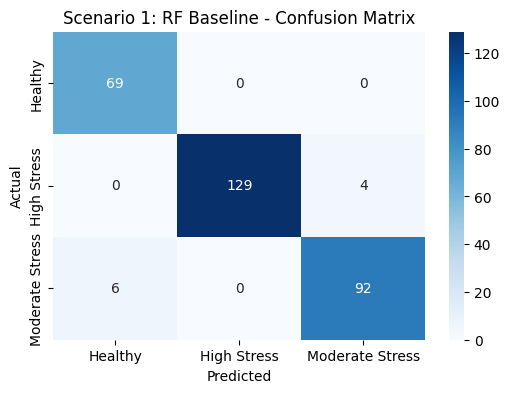

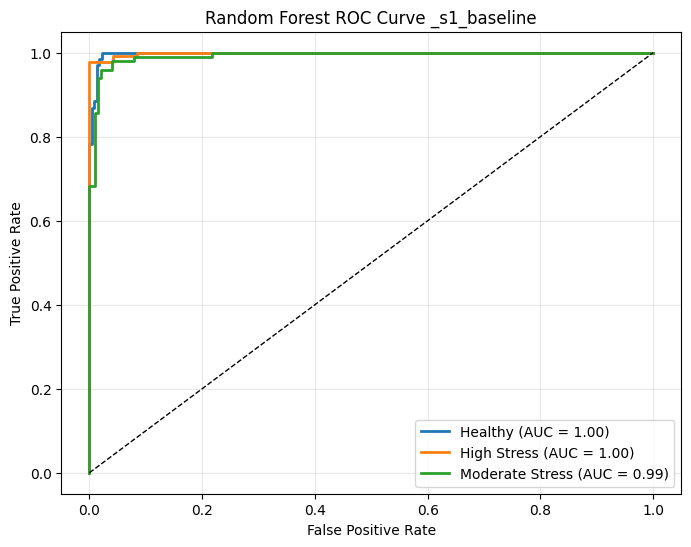

In [4]:
rf1, tr1, te1, au1 = rf_baseline(X_train, X_test, y_train_clean, y_test, label_encoder)
tr1, te1, au1

## Scenario 2: RF + MI


[Scenario 2: RF + MI] Classification Report
                 precision    recall  f1-score   support

        Healthy       0.92      1.00      0.96        69
    High Stress       1.00      0.97      0.98       133
Moderate Stress       0.96      0.94      0.95        98

       accuracy                           0.97       300
      macro avg       0.96      0.97      0.96       300
   weighted avg       0.97      0.97      0.97       300

[Scenario 2 RF + MI] Train accuracy: 1.0000
[Scenario 2 RF + MI] Test accuracy:  0.9667
Fold scores: [0.99382716 0.99382716 1.         0.98765432 1.        ]
Mean: 0.9950617283950617 Std: 0.004619330107128343
[Scenario 2 CV Accuracy]: 0.9951
[Scenario 2 RF + MI] Test AUC (macro): 0.9948


(1.0, 0.9666666666666667, 0.9947701052585364)

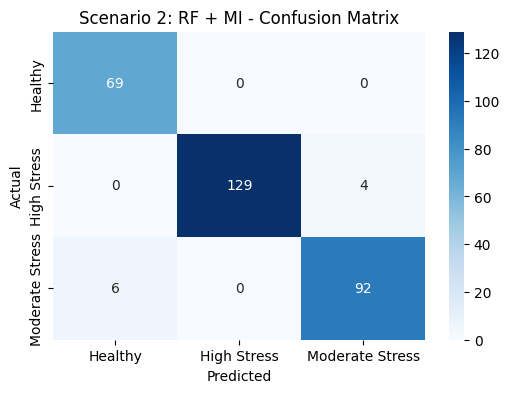

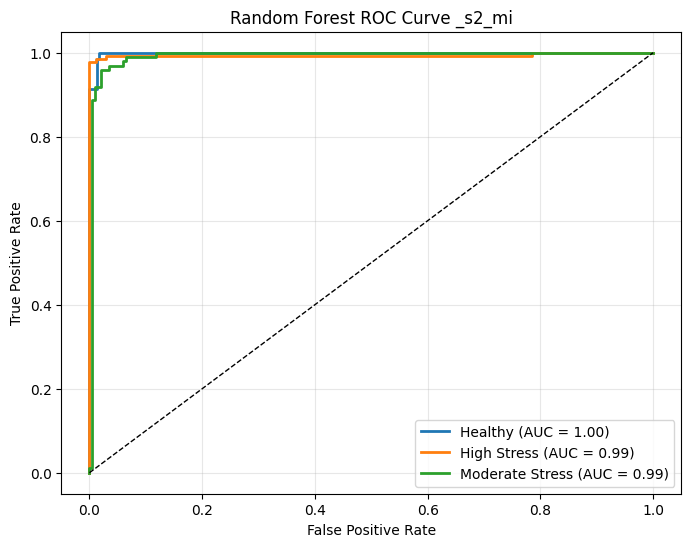

In [5]:
rf2, tr2, te2, au2 = rf_mi_only(X_train, X_test, y_train_clean, y_test, label_encoder)
tr2, te2, au2

# Scenario 3: RF tuned

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[Scenario 3: RF tuned] Best Params: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

[Scenario 3: RF tuned] Classification Report
                 precision    recall  f1-score   support

        Healthy       0.93      1.00      0.97        69
    High Stress       1.00      0.97      0.98       133
Moderate Stress       0.96      0.95      0.95        98

       accuracy                           0.97       300
      macro avg       0.96      0.97      0.97       300
   weighted avg       0.97      0.97      0.97       300

[Scenario 3 RF tuned] Train accuracy: 1.0000
[Scenario 3 RF tuned] Test accuracy:  0.9700
Fold scores: [0.99382716 0.99382716 1.         0.98765432 1.        ]
Mean: 0.9950617283950617 Std: 0.004619330107128343
[Scenario 3 CV Accuracy]: 0.9951
[Scenario 3 RF tuned] Test AUC (macro): 0.9963


(1.0, 0.97, 0.9962788888178249)

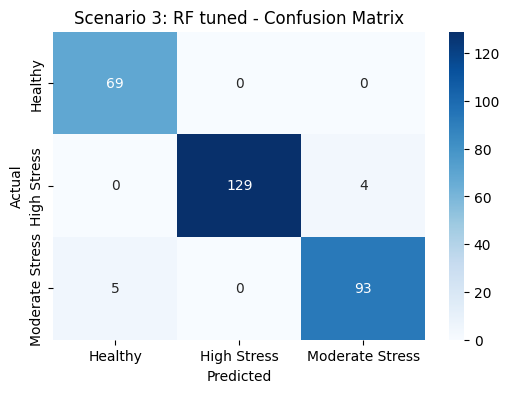

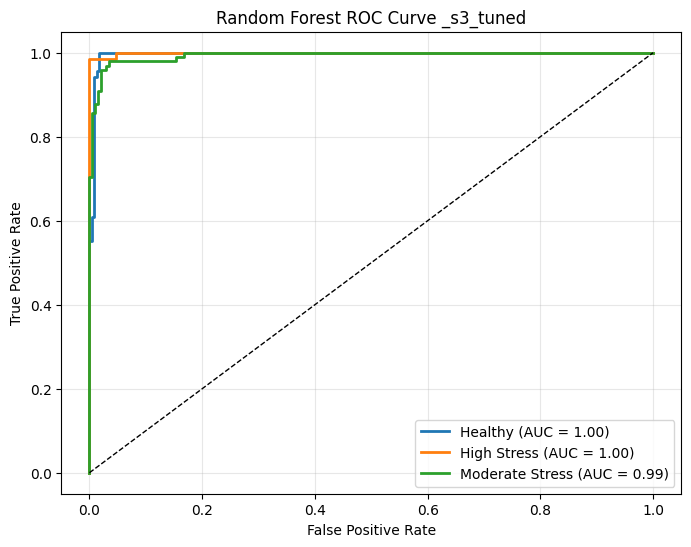

In [6]:
rf3, tr3, te3, au3 = rf_tuned_only(X_train, X_test, y_train_clean, y_test, label_encoder)
tr3, te3, au3

# Scenario 4: RF + MI tuned

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[Scenario 4: RF + MI tuned] Best Params: {'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

[Scenario 4: RF + MI tuned] Classification Report
                 precision    recall  f1-score   support

        Healthy       0.93      1.00      0.97        69
    High Stress       1.00      0.97      0.98       133
Moderate Stress       0.96      0.95      0.95        98

       accuracy                           0.97       300
      macro avg       0.96      0.97      0.97       300
   weighted avg       0.97      0.97      0.97       300

[Scenario 4 RF + MI tuned] Train accuracy: 1.0000
[Scenario 4 RF + MI tuned] Test accuracy:  0.9700
Fold scores: [0.99382716 0.99382716 1.         0.99382716 1.        ]
Mean: 0.9962962962962962 Std: 0.0030240614108434432
[Scenario 4 CV Accuracy]: 0.9963
[RF + MI tuned_s4_mi_tuned] Test AUC (macro): 0.9947


(1.0, 0.97, 0.9946759315778116)

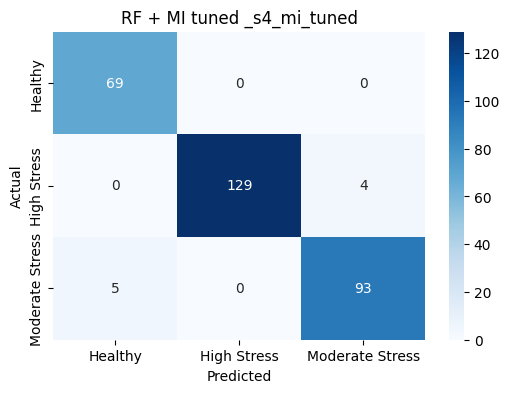

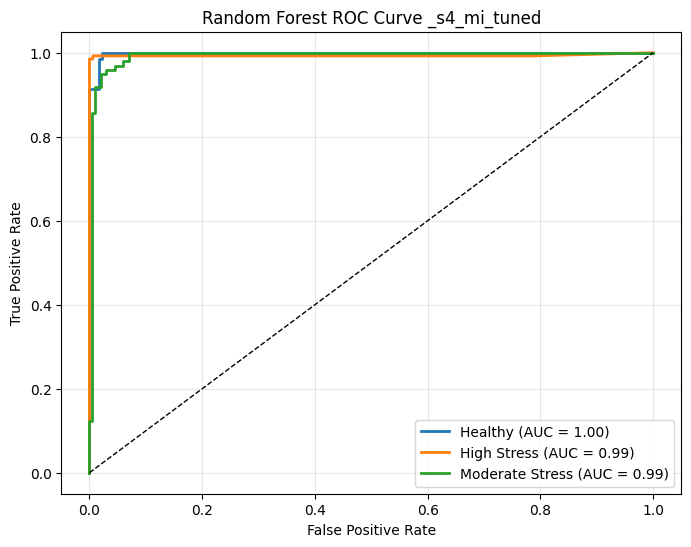

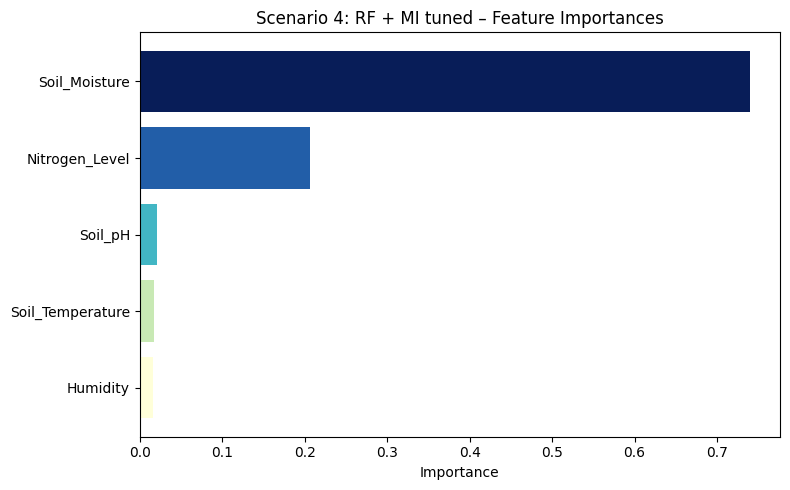

In [7]:
rf4, tr4, te4, au4, mi_names_s4 = rf_mi_tuned(X_train, X_test, y_train_clean, y_test, label_encoder, feature_names=list(X_train_df.columns),)

# Plotting the most important features
plot_feature_importances(
    rf4,
    feature_names=mi_names_s4,
    title="Scenario 4: RF + MI tuned – Feature Importances",
    filename="rf_s4_mi_tuned_no_if_feature_importances.png",
)

tr4, te4, au4

## Scenario 5: RF + MI tuned (NO IsolationForest outlier removal)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[Scenario 4: RF + MI tuned] Best Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 100}

[Scenario 4: RF + MI tuned] Classification Report
                 precision    recall  f1-score   support

        Healthy       0.92      1.00      0.96        69
    High Stress       1.00      0.97      0.98       133
Moderate Stress       0.96      0.94      0.95        98

       accuracy                           0.97       300
      macro avg       0.96      0.97      0.96       300
   weighted avg       0.97      0.97      0.97       300

[Scenario 4 RF + MI tuned] Train accuracy: 1.0000
[Scenario 4 RF + MI tuned] Test accuracy:  0.9667
Fold scores: [0.99444444 0.99444444 1.         0.98888889 1.        ]
Mean: 0.9955555555555555 Std: 0.004157397096415476
[Scenario 4 CV Accuracy]: 0.9956
[RF + MI tuned_s5_mi_tuned_no_if] Test AUC (macro): 0.9965


(1.0, 0.9666666666666667, 0.9964916976324978)

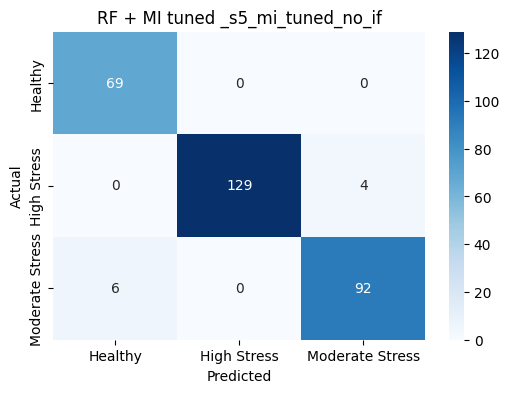

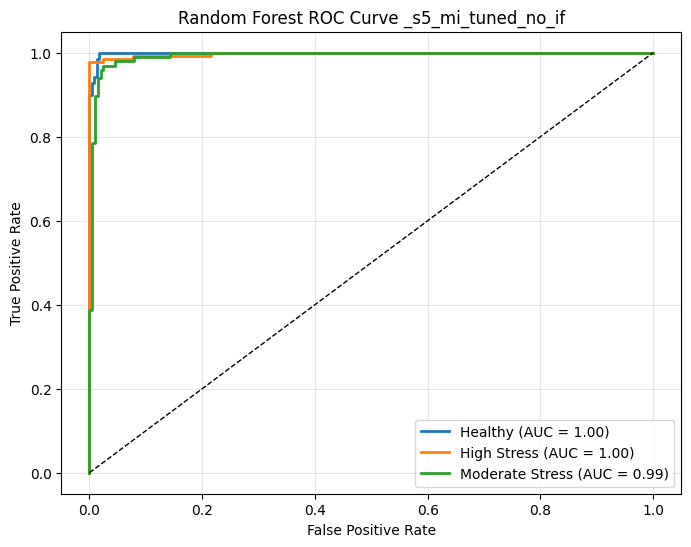

In [8]:
# Encode labels on the full (non-IF) training set
label_encoder_no_if = LabelEncoder()
y_train_no_if = label_encoder_no_if.fit_transform(y_train_series.values)
y_test_no_if = label_encoder_no_if.transform(y_test_series.values)

X_train_no_if = X_train_df.values
X_test_no_if = X_test_df.values

rf5, tr5, te5, au5, _ = rf_mi_tuned(
    X_train_no_if,
    X_test_no_if,
    y_train_no_if,
    y_test_no_if,
    label_encoder_no_if,
    title_suffix="_s5_mi_tuned_no_if",
)

tr5, te5, au5

## Results summarized

In [9]:
summary = pd.DataFrame(
    [
        ("Scenario 1: Baseline RF", tr1, te1, au1),
        ("Scenario 2: RF + MI", tr2, te2, au2),
        ("Scenario 3: RF tuned", tr3, te3, au3),
        ("Scenario 4: RF + MI tuned", tr4, te4, au4),
        ("Scenario 5: RF + MI tuned (no IF)", tr5, te5, au5),
    ],
    columns=["Scenario", "Train Accuracy", "Test Accuracy", "Test AUC"],
)
summary

,Scenario,Train Accuracy,Test Accuracy,Test AUC
0,Scenario 1: Baseline RF,1.0,0.966667,0.996457
1,Scenario 2: RF + MI,1.0,0.966667,0.994770
2,Scenario 3: RF tuned,1.0,0.970000,0.996279
3,Scenario 4: RF + MI tuned,1.0,0.970000,0.994676
4,Scenario 5: RF + MI tuned (no IF),1.0,0.966667,0.996492


## Summary of Results

The table above shows that **all scenarios perform extremely well**:

- Test accuracies range from **0.96667 to 0.97**.
- AUC values are all around **0.99–1.0**, indicating really good separability between plant health classes

We see the baseline random forest performing with the same test accuracy as a hyperparameter tuned model with feature selection. This indicates that the random forest classifier can learn the decision boundaries between the plant health classes almost perfectly. To break down some potential ideas about why this may be:

- Looking at our feature importances plot, we can see there are two main features driving the predictions. Soil mosture accounts for ~63% of the predictive power, and Nitrogen level is ~16%. This shows the outcome is strongly determined by only 2 of the features, which limits the amount of branching we need in the decision trees.
- Our dataset is numeric, nonlinear data which works very well with random forest classifiers
- Our dataset also appears very clean, there is minimal noise, and we don't see any drop in classification performance when we keep the outliers in the data. 